#New simulation Cavity-Qubit-NR


In [1]:
#import functions
%pylab inline

# from MyUnits import *
from MyFunctions import *
from qutip import *

# from MyQubit import *
# import mpld3
import multiprocessing as mp
import itertools

from qutip.ui.progressbar import BaseProgressBar, TextProgressBar




Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.constants as sc

In [3]:
import time

In [4]:
def calc_spectrum_5(N,M,P, Ej, Ec, w_nr, w_c, g0, n_ac, n_dc, A , w):
    
    w_q = sqrt(8 * Ec * Ej) - Ec
    zeta = Ej/Ec
    
    # qubit operators
    
    a = tensor(destroy(N),qeye(M),qeye(P))
    n_a = a.dag() * a
    x_a = a.dag() + a
    p_a = a - a.dag()
    
    
    # mechanical resonator operators
    
    b = tensor(qeye(N),destroy(M),qeye(P))
    n_b = b.dag() * b
    x_b = b.dag() + b
    p_b = b - b.dag()
    
    
    # CPW operators
    
    c = tensor(qeye(N),qeye(M),destroy(P))
    n_c = c.dag() * c
    x_c = c.dag() + c
    p_c = c - c.dag()
    
    # Identity
    
    I = tensor(qeye(N),qeye(M),qeye(P))
    
    
    # Hamiltonian
    
    
    H1 = sqrt(Ec*Ej/2) *(2 + 4 * a.dag()*a) - Ec/12 * (a + a.dag())**4
    
    # H1 = w_q * a.dag() * a - Ec/12 * (a.dag())**2 * a**2
    
    H2 = w_nr * (b.dag() * b - I/2)
    
    H3 = w_c * (c.dag() * c - I/2)
    
    H4 = 4 * Ec * n_dc**2 * x_b**2
    
    H5 = 4 * Ec * n_ac**2 * x_c**2
    
    H6 = 4 * 1j * Ec * n_ac * (zeta/2)**(1/4) * p_a * x_c
    
    H7 = 4 * g0 * n_dc**2 * x_b**3
    
    H8 = 8 * Ec * n_dc * n_ac * x_b * x_c
    
    H9 = 4 * 1j * Ec * n_dc * (zeta/2)**(1/4) * p_a * x_b
    
    H10 = 8 * g0 * n_dc * n_ac * x_b**2 * x_c 
    
    H11 = 4 * 1j * g0 * n_dc * (zeta/2)**(1/4) * p_a * x_b**2
    
    H12 = 4 * g0 * n_ac**2 * x_c**2 * x_b 
    
    H13 = 4 * 1j * g0 * n_ac * (zeta/2)**(1/4) * p_a * x_b * x_c
    
    H14 = - g0 * sqrt(zeta/2) * p_a**2 * x_b
    
    # Time domain
    
    
    
    
    # Colapse Operators
    
    c_op_list = []
    
    kappa = 0.001
    gamma = 0.001
    Gamma = 0.001
    Gamma_m = 0.001
    n_th_a = 0.1
    
    rate = kappa * (1 + n_th_a)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * c)

    rate = kappa * n_th_a
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * c.dag())

    rate = gamma
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * a)

    rate = Gamma
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * a.dag())   
    
    rate = Gamma_m
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * b.dag()) 

    
    H0 = H1 + H2 + H3 + H4 + H5 + H6 + H8 + H9 + H7+ H10 + H11 + H12 + H13 + H14
    
    
   
    
    
    return H0

In [5]:

phi = linspace(0,pi,100)
Ej_vec =  Ej_max * abs(cos(phi))*sqrt(1+(d*tan(phi))**2)
energies = array([calc_spectrum_5
                  (N,M,P, Ej, Ec, w_nr, w_c, g0, n_ac, n_dc, A , w).eigenenergies()
                  for Ej in Ej_vec])

NameError: name 'Ej_max' is not defined

NameError: name 'energies' is not defined

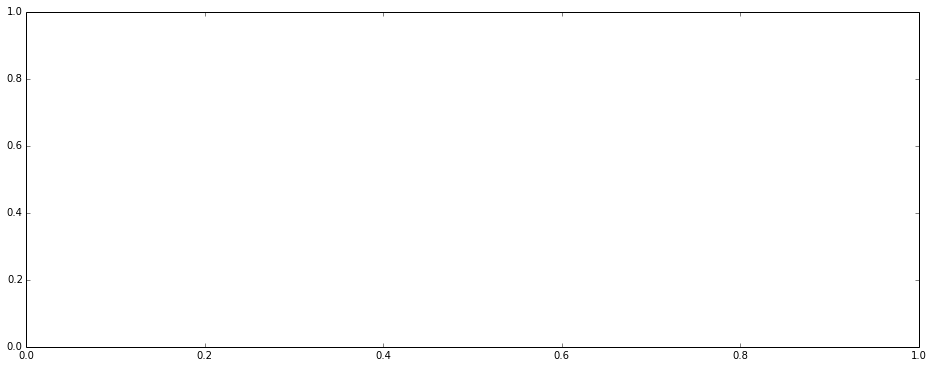

In [6]:
fig, axes = subplots(1,1, figsize=(16,6))
x_inf = -1
x_sup = 10

for n in range(len(energies[0,:])):
    axes.plot(phi/pi, (energies[:,n]-energies[:,0]),'-')
#     axes.plot(phi/pi, (energies[:,n]-energies[:,0])/2,'--')
    
    if n < 4:
        axes.text(.2,energies[0,n]-energies[0,0],r'|%s>'%(n),fontsize=20)
    
axes.set_title('Full')
axes.set_ylim(x_inf, x_sup)
axes.set_xlabel(r'$\phi$', fontsize=18)
axes.set_ylabel(r'$E_n-E_0$', fontsize=18)
axes.hlines(w_nr,.2,.4,linestyles='dashed')
axes.hlines(w_c,.2,.4,linestyles='dashed')
axes.vlines(0.33,0,10,linestyles='dashed')


In [7]:
def Ht(t, args):
    #
    # evaluate the hamiltonian at time t. 
    #
    
    H0 = args['H0']
    a = args['a']
    aDag = args['aDag']
    A = args['A']
    
    w  = args['w']

    return H0 + A * (a*sin(w*t) + aDag*cos(w*t))  #(a * exp(1j*w*t) + aDag * exp(-1j*w*t))

In [8]:
def calc_spectrum_4(N,M,P, Ej, Ec, w_nr, w_c, g0, n_ac, n_dc, A , w):
    
    w_q = sqrt(8 * Ec * Ej) - Ec
    zeta = Ej/Ec
    
    # qubit operators
    
    a = tensor(destroy(N),qeye(M),qeye(P))
    n_a = a.dag() * a
    x_a = a.dag() + a
    p_a = a - a.dag()
    
    
    # mechanical resonator operators
    
    b = tensor(qeye(N),destroy(M),qeye(P))
    n_b = b.dag() * b
    x_b = b.dag() + b
    p_b = b - b.dag()
    
    
    # CPW operators
    
    c = tensor(qeye(N),qeye(M),destroy(P))
    n_c = c.dag() * c
    x_c = c.dag() + c
    p_c = c - c.dag()
    
    # Identity
    
    I = tensor(qeye(N),qeye(M),qeye(P))
    
    
    # Hamiltonian
    
    
    H1 = sqrt(Ec*Ej/2) *(2 + 4 * a.dag()*a) - Ec/12 * (a + a.dag())**4
    
    # H1 = w_q * a.dag() * a - Ec/12 * (a.dag())**2 * a**2
    
    H2 = w_nr * (b.dag() * b - I/2)
    
    H3 = w_c * (c.dag() * c - I/2)
    
    H4 = 4 * Ec * n_dc**2 * x_b**2
    
    H5 = 4 * Ec * n_ac**2 * x_c**2
    
    H6 = 4 * 1j * Ec * n_ac * (zeta/2)**(1/4) * p_a * x_c
    
    H7 = 4 * g0 * n_dc**2 * x_b**3
    
    H8 = 8 * Ec * n_dc * n_ac * x_b * x_c
    
    H9 = 4 * 1j * Ec * n_dc * (zeta/2)**(1/4) * p_a * x_b
    
    H10 = 8 * g0 * n_dc * n_ac * x_b**2 * x_c 
    
    H11 = 4 * 1j * g0 * n_dc * (zeta/2)**(1/4) * p_a * x_b**2
    
    H12 = 4 * g0 * n_ac**2 * x_c**2 * x_b 
    
    H13 = 4 * 1j * g0 * n_ac * (zeta/2)**(1/4) * p_a * x_b * x_c
    
    H14 = - g0 * sqrt(zeta/2) * p_a**2 * x_b
    
    # Time domain
    
    
    
    
    # Colapse Operators
    
    c_op_list = []
    
    kappa = 0.001
    gamma = 0.001
    Gamma = 0.001
    Gamma_m = 0.001
    n_th_a = 0.1
    
    rate = kappa * (1 + n_th_a)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * c)

    rate = kappa * n_th_a
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * c.dag())

    rate = gamma
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * a)

    rate = Gamma
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * a.dag())   
    
    rate = Gamma_m
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * b.dag()) 

    
    H0 = H1 + H2 + H3 + H4 + H5 + H6 + H8 + H9 + H7+ H10 + H11 + H12 + H13 + H14
    
    
    H_args = {'H0': H0, 'a': a, 'aDag': a.dag() , 'A' : A , 'w': w}
    
#     rho = steadystate(H,c_op_list)
    
    T = 2 * pi / w

    U = propagator(Ht, T, c_op_list, H_args)

    rho_ss = propagator_steadystate(U)

#     rho_a = rho_ss*a
#     rho_b = rho_ss*b
    rho_c = rho_ss*c

    
    
    return rho_c.tr()




In [9]:
N,M,P = 3, 10 ,10

# qubit Cavity parameters
Ej_max = 16 
Ej = 4 
Ec = 0.2 
w_nr = 3.5 
w_c = 5  
Cg = 10e-15 
Cc = 1e-12
Cb = 50e-15
Cnr = 2e-17

# mechanical resonator

m = (700e-9)*(65e-9)*(100e-9)*2700 
Xzpm = sqrt(sc.hbar/(2*m*w_nr*2*pi*1e9))
print('X_ZPM =',Xzpm)
d0 = 30e-9 
g0 = Ec/d0 *Cnr/(Cg+Cb+Cnr)*Xzpm*1e9
print('g0 =', g0)

# Cavity effect
n_ac = Cg /2/sc.e * sqrt(sc.h*w_c*2*pi*1e9/2/Cc)
print('N_ac =',n_ac)

V_dc = 10

n_dc = Cnr*V_dc/2/sc.e*Xzpm*1e9

print('n_dc = ',n_dc)

d = 0.1 # asymetry 

A = 0.0003# field aplitude

w = 5.001
print('E_q =', sqrt(8 * Ec * Ej_max) - Ec)



X_ZPM = 1.39704864016e-14
g0 = 0.0310351802769
N_ac = 0.100681009983
n_dc =  0.00871969214058
E_q = 4.85964425627


In [ ]:
to = datetime.datetime.now()
calc_spectrum_4(N,M,P, Ej, Ec, w_nr, w_c, g0, n_ac, n_dc, A , w)
t1 = datetime.datetime.now()
t1-to

In [10]:
w = linspace(4.9,5.2,12) 
    
phi = linspace(0,pi,5)

Ej_vec =  Ej_max * abs(cos(phi))*sqrt(1+(d*tan(phi))**2)


# a , b = zip(*itertools.product(Ej_vec,w))

# energies_CPB = array([CPB(Ec,Ej,N,ng).eigenenergies() for Ej in Ej_vec])
# energies = array([hamiltonian(Ec, Ej, N, ng).eigenenergies() for Ej in Ej_vec])
# energies = array([calc_spectrum_4(N,M,P, Ej,Ec, w_nr, w_c, g0, n_ac, n_dc).eigenenergies() for Ej in Ej_vec])

In [11]:
progress_bar = TextProgressBar()
    
progress_bar.start(len(Ej_vec))
nfinished = [0]

def _update_progress_bar(x):
    nfinished[0] += 1
    progress_bar.update(nfinished[0])
        
results = []        
for a in Ej_vec:


    try:
        pool = mp.Pool(processes=12)
        
#         task_args = a,z
        async_res = [pool.apply_async(calc_spectrum_4,
                             (N,
                              M,
                              P,
                              a,
                              Ec,
                              w_nr,
                              w_c,
                              g0,
                              n_ac,
                              n_dc,
                              A,
                              b)) for b in w]


        while not all([ar.ready() for ar in async_res]):
            for ar in async_res:
                ar.wait(timeout=0.1)

        pool.terminate()
        pool.join()
        results.append([ar.get() for ar in async_res])
    except KeyboardInterrupt as e:
        pool.terminate()
        pool.join()
        raise e
    _update_progress_bar(1)
    
progress_bar.finished()



# pool = mp.Pool(processes=12)
# t0 = time.time()
# results1 = [pool.apply_async(calc_spectrum_4,
#                              (N,
#                               M,
#                               P,
#                               a1,
#                               Ec,
#                               w_nr,
#                               w_c,
#                               g0,
#                               n_ac,
#                               n_dc,
#                               A,
#                               b1)) for a1 , b1 in zip(a,b)]


# results1 = [pool.apply_async(calc_spectrum_4,
#                              (N,
#                               M,
#                               P,
#                               Ej,
#                               Ec,
#                               w_nr,
#                               w_c,
#                               g0,
#                               n_ac,
#                               n_dc,
#                               A,
#                               w)) for a1 , b1 in zip(a,b)]


# t1 = time.time()
# print("elapsed =", (t1-t0))


# results = [p.get() for p in async_res]





KeyboardInterrupt: 

In [ ]:
# results
# qsave(results, 'steadystate')

In [43]:
shape(results)
# results

(5, 12)

In [45]:
tr = reshape(results,(-1,len(w+1)))
shape(tr)
# tr

(5, 12)

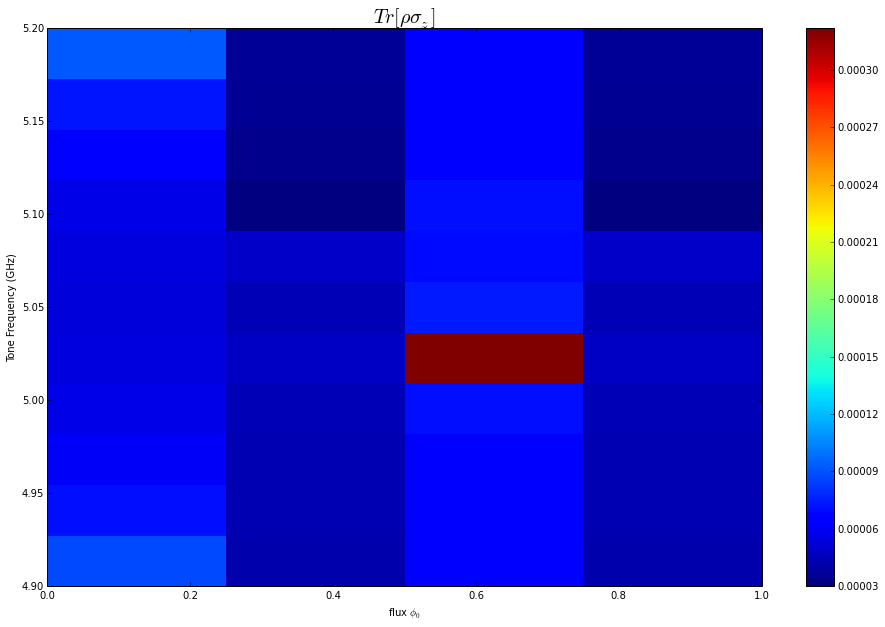

In [48]:
fig, ax = subplots(1,1, figsize=(16,10))

im = ax.pcolor(phi/pi,w,transpose(abs(tr)))#,vmin=0, vmax=1)
fig.colorbar(im, ax=ax)
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
ax.set_ylabel(r'Tone Frequency (GHz)',fontsize=10)
ax.set_xlabel(r'flux $\phi_0$',fontsize=10)
ax.set_title(r'$Tr[\rho\sigma_z]$',fontsize=20)

ValueError: x and y must have same first dimension

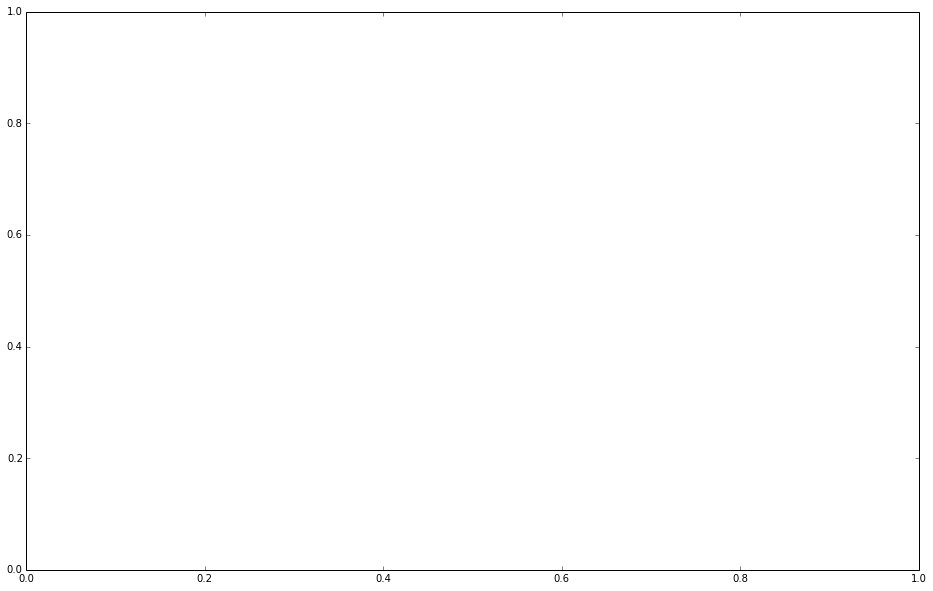

In [49]:
fig, axes = subplots(1,1, figsize=(16,10))
x_inf = 4.9
x_sup = 5.2

for n in range(len(energies[0,:])):
    axes.plot(phi/pi, (energies[:,n]-energies[:,0]),'-')
#     axes.plot(phi/pi, (energies[:,n]-energies[:,0])/2,'--')
    
#     if n < 4:
#         axes.text(.2,energies[0,n]-energies[0,0],r'|%s>'%(n),fontsize=20)
    
axes.set_title('Full')
axes.set_ylim(x_inf, x_sup)
axes.set_xlabel(r'$\phi$', fontsize=18)
axes.set_ylabel(r'Cavity Tone Frequency GHz', fontsize=18)
axes.hlines(w_nr,.2,.4,linestyles='dashed')
axes.hlines(w_c,.2,.4,linestyles='dashed')
axes.vlines(0.33,0,10,linestyles='dashed')

im = axes.pcolor(phi/pi,w,transpose(log(abs(tr))))#,vmin=0, vmax=1)
fig.colorbar(im, ax=axes)
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
# axes.set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
# axes.set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
# axes.set_title(r'$Tr[\rho\sigma_z]$',fontsize=20)


In [ ]:
pool = mp.Pool(processes=12)
t0 = time.time()
results1 = [pool.apply_async(calc_spectrum_4,
                             (N,
                              M,
                              P,
                              a1,
                              Ec,
                              w_nr,
                              w_c,
                              g0,
                              n_ac,
                              n_dc,
                              A,
                              b1)) for a1 , b1 in zip(a,b)]


# results1 = [pool.apply_async(calc_spectrum_4,
#                              (N,
#                               M,
#                               P,
#                               Ej,
#                               Ec,
#                               w_nr,
#                               w_c,
#                               g0,
#                               n_ac,
#                               n_dc,
#                               A,
#                               w)) for a1 , b1 in zip(a,b)]


t1 = time.time()
print("elapsed =", (t1-t0))


results = [p.get() for p in results1]



# Device Data 


In [8]:
Ej = 11.55 # Maximum Josephson Energy

Ec = 0.22 # Capacitive Energy

w_ge_max = sqrt(8*Ec*Ej)-Ec
print('Qubit max frequency: ',w_ge_max, 'GHz')


f = w_ge_max *1e9 # GHz
T = 50e-3 # K

n_th_a = 1/(exp(sc.h*f/(sc.k*T)-1))

print('<n> thermal: ',n_th_a)



Qubit max frequency:  4.28865833702 GHz
<n> thermal:  0.0443136288802


In [96]:
a1, b1 = zip(*itertools.product(A_Q, Delta_Q))

## Simulation 

In [97]:
pool = mp.Pool(processes=12)
t0 = time.time()
results1 = [pool.apply_async(calc_spectrum_3,
                            (N,
                             M,
                             Delta_C,
                             Delta_NR,
                             y,
                             g,
                             lamb,
                             A_C,
                             x,   
                             A_NR,
                             kappa_n,
                             gamma_rel,
                             gamma_dep,
                             n_th_a)) for x , y in zip(a1,b1)]

t1 = time.time()
print("elapsed =", (t1-t0))
# results2 = [pool.apply_async(calc_spectrum_3,
#                             (N,
#                              M,
#                              Delta_C,
#                              Delta_NR,
#                              Delta_Q,
#                              g,
#                              lamb,
#                              A_C,
#                              A_Q   
#                              A_NR,
#                              kappa_n,
#                              gamma_rel,
#                              gamma_dep,
#                              n_th_a)) for x , y in zip(a1,b1)]

results = [p.get() for p in results1]




elapsed = 82.38939642906189


In [ ]:
p

In [98]:
shape(results)

(10000, 3)

In [99]:
Tr_sz = reshape(array(results)[:,0],(-1,len(Delta_Q+1)))
Tr_a = reshape(array(results)[:,1],(-1,len(Delta_Q+1)))
Tr_b = reshape(array(results)[:,2],(-1,len(Delta_Q+1)))

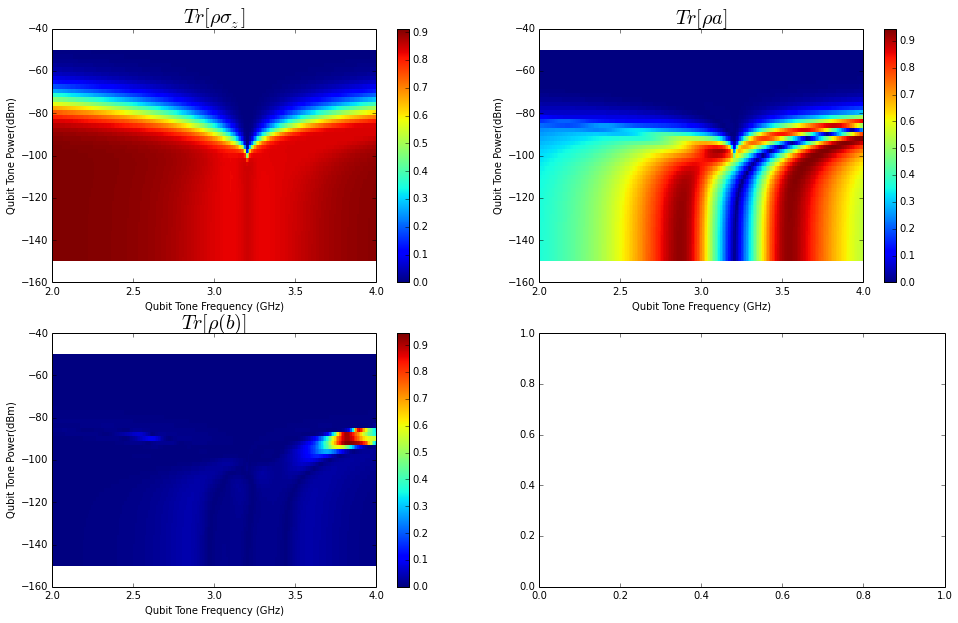

In [100]:
fig, ax = subplots(2,2, figsize=(16,10))

im = ax[0,0].pcolor(  w_s/2/pi,P_Q,abs(Tr_sz))#,vmin=0, vmax=1)
fig.colorbar(im, ax=ax[0,0])
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
ax[0,0].set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
ax[0,0].set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
ax[0,0].set_title(r'$Tr[\rho\sigma_z]$',fontsize=20)


im2 = ax[0,1].pcolor(w_s/2/pi,P_Q,abs(Tr_a))#,vmin=0, vmax=1)
fig.colorbar(im2, ax=ax[0,1])
# ax[0,1].set_ylim(P_i,P_f)
# ax[0,1].set_xlim(4.27,4.39)
ax[0,1].set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
ax[0,1].set_xlabel(r'Qubit Tone Frequency (GHz)', fontsize=10)
ax[0,1].set_title(r'$Tr[\rho {a}]$',fontsize=20)

im3 = ax[1,0].pcolor(w_s/2/pi,P_Q,abs(Tr_b))#,vmin=0, vmax=1)
fig.colorbar(im2, ax=ax[1,0])
# ax[1,0].set_ylim(P_i,P_f)
# ax[1,0].set_xlim(4.27,4.39)
ax[1,0].set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
ax[1,0].set_xlabel(r'Qubit Tone Frequency (GHz)', fontsize=10)
ax[1,0].set_title(r'$Tr[\rho (b)]$',fontsize=20)

##Simulation 2

In [72]:
Q_c = 20000
Q_l = Q_c


N = 5
M = 5


g = 0.1
lamb = 0.1



kappa_n = 0.0002
gamma_rel = 0.0002
gamma_dep = 0.001


# Cavity
w_c = 5 * (2 * pi)
w_d = (2 * pi) * linspace(4.9,5.1,30)# 4.995 # 0.006283185307175643
P_C = -120# linspace(-60,-150,20)

# Nanoresonator
w_NR = 3 * (2 * pi)
w_p = 2.9996 # (2 * pi) * linspace(2.95,3.05,50)
P_NR = -100


# Qubit
w_q =  3.1 * (2 * pi)
w_s = (2 * pi) *linspace(2.8,3.3,300)
P_Q = -100 # linspace(-50,-150,50)



In [73]:
Delta_C = Delta(w_c, w_d) 

Delta_NR = Delta(w_NR, w_p)

Delta_Q = Delta(w_q, w_s)
# print(Delta_C,Delta_NR,Delta_Q) 

In [74]:
A_C = Gamma(P_C,Q_c,Q_l,kappa_n,w_c)

A_Q = Gamma(P_Q,Q_c,Q_l,kappa_n,w_q)

A_NR = Gamma(P_NR,Q_c,Q_l,kappa_n,w_NR)
# print(r'A_C = ', A_C, '\n\nA_Q = ', A_Q, '\n\nA_NR = ' , A_NR) 

In [77]:
a1, b1 = zip(*itertools.product(Delta_Q, Delta_C))

In [78]:
pool = mp.Pool(processes=12)
t0 = time.time()
results1 = [pool.apply_async(calc_spectrum_3,
                            (N,
                             M,
                             y,
                             Delta_NR,
                             x,
                             g,
                             lamb,
                             A_C,
                             A_Q,   
                             A_NR,
                             kappa_n,
                             gamma_rel,
                             gamma_dep,
                             n_th_a)) for x , y in zip(a1,b1)]

t1 = time.time()
print("elapsed =", (t1-t0))
# results2 = [pool.apply_async(calc_spectrum_3,
#                             (N,
#                              M,
#                              Delta_C,
#                              Delta_NR,
#                              Delta_Q,
#                              g,
#                              lamb,
#                              A_C,
#                              A_Q   
#                              A_NR,
#                              kappa_n,
#                              gamma_rel,
#                              gamma_dep,
#                              n_th_a)) for x , y in zip(a1,b1)]

results = [p.get() for p in results1]





elapsed = 6.746828556060791


In [79]:
shape(results)

(9000, 3)

In [80]:
Tr_sz = reshape(array(results)[:,0],(-1,len(Delta_C+1)))
Tr_a = reshape(array(results)[:,1],(-1,len(Delta_C+1)))
Tr_b = reshape(array(results)[:,2],(-1,len(Delta_C+1)))

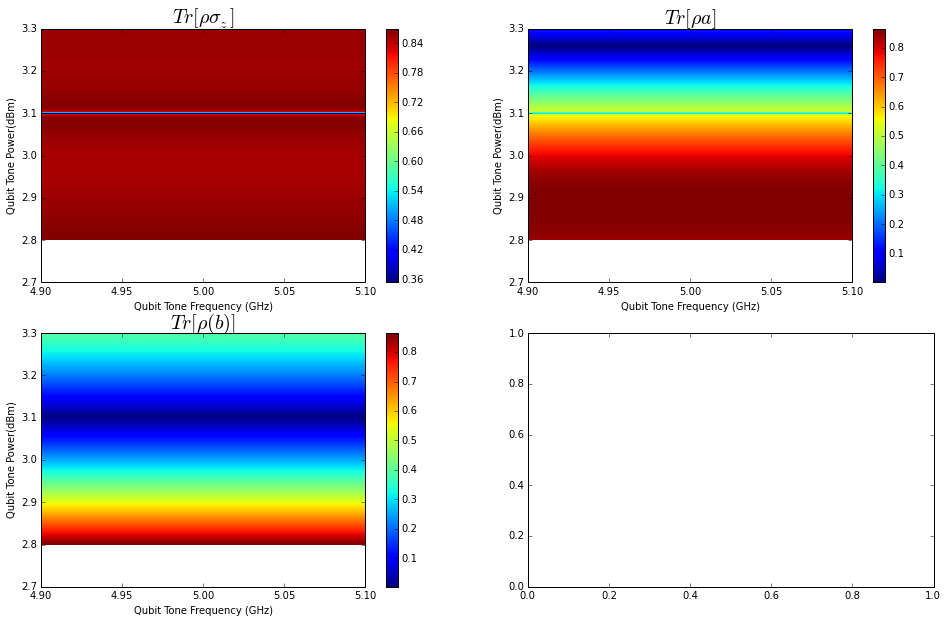

In [83]:
fig, ax = subplots(2,2, figsize=(16,10))

im = ax[0,0].pcolor(  w_d/2/pi,w_s/2/pi,abs(Tr_sz))#,vmin=0, vmax=1)
fig.colorbar(im, ax=ax[0,0])
# ax[0,0].set_xlim(4.27,4.39)
# ax[0,0].set_ylim(P_i,P_f)
ax[0,0].set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
ax[0,0].set_xlabel(r'Qubit Tone Frequency (GHz)',fontsize=10)
ax[0,0].set_title(r'$Tr[\rho\sigma_z]$',fontsize=20)


im2 = ax[0,1].pcolor(w_d/2/pi,w_s/2/pi,abs(Tr_a))#,vmin=0, vmax=1)
fig.colorbar(im2, ax=ax[0,1])
# ax[0,1].set_ylim(P_i,P_f)
# ax[0,1].set_xlim(4.27,4.39)
ax[0,1].set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
ax[0,1].set_xlabel(r'Qubit Tone Frequency (GHz)', fontsize=10)
ax[0,1].set_title(r'$Tr[\rho {a}]$',fontsize=20)

im3 = ax[1,0].pcolor(w_d/2/pi,w_s/2/pi,abs(Tr_b))#,vmin=0, vmax=1)
fig.colorbar(im2, ax=ax[1,0])
# ax[1,0].set_ylim(P_i,P_f)
# ax[1,0].set_xlim(4.27,4.39)
ax[1,0].set_ylabel(r'Qubit Tone Power(dBm)',fontsize=10)
ax[1,0].set_xlabel(r'Qubit Tone Frequency (GHz)', fontsize=10)
ax[1,0].set_title(r'$Tr[\rho (b)]$',fontsize=20)